![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Copyright:** 2025 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Micheal Schick (EUMETSAT), Serena Avolio (EUMETSAT/Starion)

<div class="alert alert-block alert-success">
<h3>Destination Earth - Climate DT Parameter - Data Access using DEDL HDA</h3></div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
   <li>To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.</li>
<b> References: </b>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/">Climate Change Adaptation DT (Climate DT)</a></li>
    <li> <a href="https://confluence.ecmwf.int/display/DDCZ/Climate+DT+Phase+1+data+catalogue">Climate DT data catalogue</a></li>
<b> Credit: </b>
    <li> Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li>
</div>


This notebook demonstrates how to use the **HDA (Harmonized Data Access)** API to query and access Climate DT data to plot a parameter series.
Below the main steps covered by this tutorial.

1. [Setup](DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb#Setup): Import the required libraries. 
2. [Order and Download](DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb#Order-and-Download): How to filter and download climate Dt data.
3. [Plot](DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE.ipynb#EarthKit): How to visualize hourly data on single levels data through Earthkit.

# Setup

Import all the required packages.

In [4]:
import destinelab as deauth
import json
import datetime
import importlib.metadata

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
from getpass import getpass
from tqdm import tqdm
import time
from datetime import datetime
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON

# Order and Download

## Obtain Authentication Token

To perform our request we need to be authenticated. 
Below to request of an authentication token.

In [5]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [6]:
import importlib
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## HDA Endpoint
HDA API is based on the Spatio Temporal Asset Catalog specification (STAC), it is convenient define a costant with its endpoint.
And another one with the ID of the Cliamte DT collection.

In [7]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
COLLECTION_ID="EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"

## Order and download data
We have to setup up a filter and define which data to obtain.

Search into asynchronous datasets, as the DTs are, always return a single item:

In [8]:
datechoice = "20280610"
filter_params = {
        "ecmwf:class": "d1",             # fixed 
        "ecmwf:dataset": "climate-dt",   # fixed climate-dt access
        "ecmwf:activity": "ScenarioMIP", # activity + experiment + model (go together)
        "ecmwf:experiment": "SSP3-7.0",  # activity + experiment + model (go together)
        "ecmwf:model": "IFS-NEMO",       # activity + experiment + model (go together)
        "ecmwf:generation": "1",         # fixed Specifies the generation of the dataset, which can be incremented as required (latest is 1)
        "ecmwf:realization": "1",        # fixed Specifies the climate realization. Default 1. Based on perturbations of initial conditions
        "ecmwf:resolution": "high",      # standard/ high 
        "ecmwf:expver": "0001",          # fixed experiment version 
        "ecmwf:stream": "clte",          # fixed climate
        "ecmwf:time": "0000",            # choose the hourly slot(s)
        "ecmwf:type": "fc",              # fixed forecasted fields
        "ecmwf:levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
#        "levelist": "1/2/3/...",  # for ml/pl/sol type data
        "ecmwf:param": "134",             # Surface Pressure parameter
        "ecmwf:date":datechoice+"/to/"+datechoice
    }

In [11]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=filter_params, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")      

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break
    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
else:
    filename = os.path.basename(url)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

Product ordered: bbcdf3e0-3515-4269-ac54-59a7c35610e7
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: shipping
Polling 1/300
Product is ready to be downloaded.
Asset URL: https://hda-download.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/bbcdf3e0-3515-4269-ac54-59a7c35610e7/downloadLink
downloading bbcdf3e0-3515-4269-ac54-59a7c35610e7.grib


23.6MB [00:00, 26.2MB/s]


## EarthKit

Lets plot the result file with [EarthKit](https://earthkit.readthedocs.io/en/latest/index.html).

In [21]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

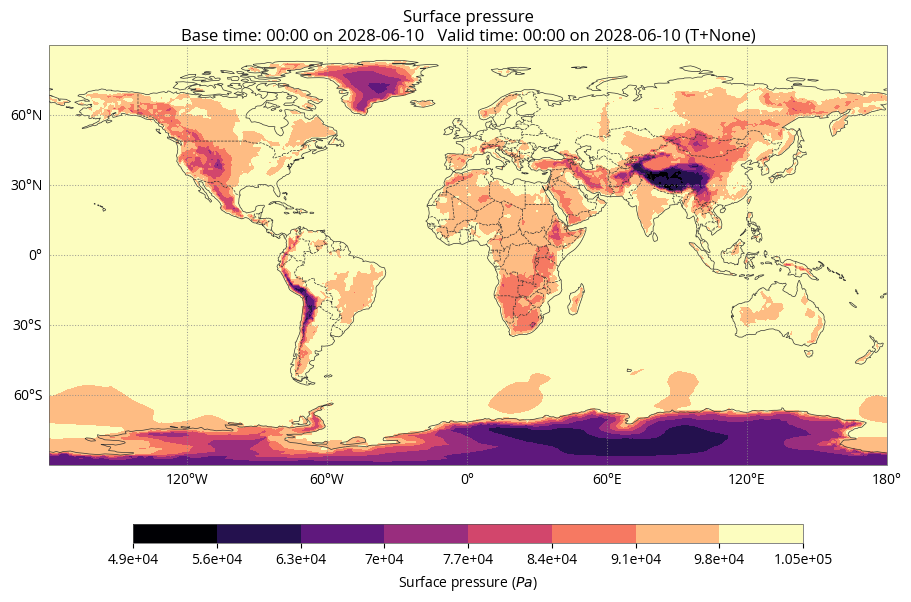

In [22]:
data = earthkit.data.from_source("file", filename)
data.ls
earthkit.maps.quickplot(data)